In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pdb
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda"

## Create DART Model

In [2]:
class DartModel(nn.Module):
    def __init__(self, lh, lo, li):
        super(DartModel, self).__init__()
        self.fi1 = nn.Linear(3, lh)
        self.fi2 = nn.Linear(lh, lo)
        
        self.fj1 = nn.Linear(3, lh)
        self.fj2 = nn.Linear(lh, lo)

        self.fk1 = nn.Linear(3, lh)
        self.fk2 = nn.Linear(lh, lo)
        
        self.fl1 = nn.Linear(3, lh)
        self.fl2 = nn.Linear(lh, lo)
        
        self.inter1 = nn.Linear(li, 256)
        self.inter2 = nn.Linear(256, 128)
        self.inter3 = nn.Linear(128, 32)
        self.inter4 = nn.Linear(32, 1)
        
    def forward(self, ai, aj, ak, al):
        ai_sum = ai.sum(axis=2)
        same_shape = ai_sum.shape
        ones = torch.ones(same_shape, device=device)
        zeros = torch.zeros(same_shape, device=device)
        make_zero = torch.where(ai_sum==0, zeros, ones)
        ai_mask = make_zero.unsqueeze(dim=2)

        aj_sum = aj.sum(axis=3)
        same_shape = aj_sum.shape
        ones = torch.ones(same_shape, device=device)
        zeros = torch.zeros(same_shape, device=device)
        make_zero = torch.where(aj_sum==0, zeros, ones)
        aj_mask = make_zero.unsqueeze(dim=3)

        ak_sum = ak.sum(axis=3)
        same_shape = ak_sum.shape
        ones = torch.ones(same_shape, device=device)
        zeros = torch.zeros(same_shape, device=device)
        make_zero = torch.where(ak_sum==0, zeros, ones)
        ak_mask = make_zero.unsqueeze(dim=3)

        al_sum = al.sum(axis=3)
        same_shape = al_sum.shape
        ones = torch.ones(same_shape, device=device)
        zeros = torch.zeros(same_shape, device=device)
        make_zero = torch.where(al_sum==0, zeros, ones)
        al_mask = make_zero.unsqueeze(dim=3)

        ######### atom_i ############
        ai = F.celu(self.fi1(ai), 0.1)
        ai = F.celu(self.fi2(ai), 0.1)
        ai = ai * ai_mask
        ######### atom_j ############
        aj = F.celu(self.fj1(aj), 0.1)
        aj = F.celu(self.fj2(aj), 0.1)
        aj = aj * aj_mask
        ######### atom_k ############
        ak = F.celu(self.fk1(ak), 0.1)
        ak = F.celu(self.fk2(ak), 0.1)
        ak = ak * ak_mask
        ######## atom_l ############
        al = F.celu(self.fl1(al), 0.1)
        al = F.celu(self.fl2(al), 0.1)
        al = al * al_mask

        ########### interactions of i, j, k and l atoms ############
        atm = ai + aj.sum(axis=2) + al.sum(axis=2) + al.sum(axis=2) # sum all interaction
        atm = F.celu(self.inter1(atm), 0.1)
        atm = F.celu(self.inter2(atm), 0.1)
        atm = F.celu(self.inter3(atm), 0.1)
        atm = self.inter4(atm)
        atm = atm * ai_mask
        return atm

Dart_model = DartModel(128, 128, 128).to(device)

def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

Dart_model.apply(init_params)

DartModel(
  (fi1): Linear(in_features=3, out_features=128, bias=True)
  (fi2): Linear(in_features=128, out_features=128, bias=True)
  (fj1): Linear(in_features=3, out_features=128, bias=True)
  (fj2): Linear(in_features=128, out_features=128, bias=True)
  (fk1): Linear(in_features=3, out_features=128, bias=True)
  (fk2): Linear(in_features=128, out_features=128, bias=True)
  (fl1): Linear(in_features=3, out_features=128, bias=True)
  (fl2): Linear(in_features=128, out_features=128, bias=True)
  (inter1): Linear(in_features=128, out_features=256, bias=True)
  (inter2): Linear(in_features=256, out_features=128, bias=True)
  (inter3): Linear(in_features=128, out_features=32, bias=True)
  (inter4): Linear(in_features=32, out_features=1, bias=True)
)

## Pre-processing of data

In [3]:
class sep_ijkl_dataset(Dataset):
    def __init__(self, file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.data = np.load(file, allow_pickle=True)
        self.ener = self.data["ener"]
        batch = self.data["desc"]
        self.ener = torch.tensor([j for i in self.ener for j in i], dtype=torch.float, device=device)
        batch_size = len(self.ener)
        max_atoms = []

        for batch_idx in range(batch_size):
            lol = batch[batch_idx]
            max_atoms.append(len(lol[0])) # find longest sequence
            max_atoms.append(max([len(i) for i in lol[1]])) # find longest sequence
            max_atoms.append(max([len(i) for i in lol[2]])) # find longest sequence
            max_atoms.append(max([len(i) for i in lol[3]])) # find longest sequence
        iic = max_atoms[0::4]
        jjc = max_atoms[1::4]
        kkc = max_atoms[2::4]
        llc = max_atoms[3::4]

        des_j = []
        des_k = []
        des_l = []
        for i in range(batch_size):
            const_atom_count_i = max(iic) - iic[i]
            const_atom_count_j = max(jjc) - jjc[i]
            const_atom_count_k = max(kkc) - kkc[i]
            const_atom_count_l = max(llc) - llc[i]
            a_j = torch.zeros(const_atom_count_i, const_atom_count_j, 3)
            a_k = torch.zeros(const_atom_count_i, const_atom_count_k, 3)
            a_l = torch.zeros(const_atom_count_i, const_atom_count_l, 3)
            des_j.append(pad_sequence([torch.tensor(i) for i in batch[i][1]] + [i for i in a_j]))
            des_k.append(pad_sequence([torch.tensor(i) for i in batch[i][2]] + [i for i in a_k]))
            des_l.append(pad_sequence([torch.tensor(i) for i in batch[i][3]] + [i for i in a_l]))
        
        self.des_i = pad_sequence([torch.tensor(batch[i][0]) for i in range(batch_size)], batch_first=True).squeeze().float().to(device)
        des_j = pad_sequence(des_j, batch_first=True)
        self.des_j = torch.transpose(des_j, 1, 2).float().to(device)

        des_k = pad_sequence(des_k, batch_first=True)
        self.des_k = torch.transpose(des_k, 1, 2).float().to(device)

        des_l = pad_sequence(des_l, batch_first=True)
        self.des_l = torch.transpose(des_l, 1, 2).float().to(device)
        
    def __len__(self):
        return len(self.ener)
    
    def __getitem__(self, idx):
        sample = {"atm_i": self.des_i[idx], "atm_j": self.des_j[idx], "atm_k": self.des_k[idx], "atm_l": self.des_l[idx], "energy": self.ener[idx]}
        return sample

## Create data-splits and dataloaders

In [4]:
desc_data = sep_ijkl_dataset("../data/small_dataset.npz")

validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(desc_data)
indices = list(range(dataset_size))
splitv = int(np.floor(validation_split * dataset_size))
splitt = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[splitt+splitv:], indices[:splitv], indices[splitv:splitt+splitv]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(desc_data, batch_size=32, sampler=train_sampler)
validloader = DataLoader(desc_data, batch_size=32, sampler=valid_sampler)
testloader = DataLoader(desc_data, batch_size=32, sampler=test_sampler)

In [5]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(Dart_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=25, verbose=True, eps=1e-09)

## Training loop

In [6]:
epochal_train_losses = []
epochal_val_losses  = []
num_epochs = 1500
epoch_freq = 1
       
def test(Dart_model, testloader):
    mae = torch.nn.L1Loss()
    rmse = torch.nn.MSELoss()
    pred_energy = torch.tensor([], device="cuda")
    real_energy = torch.tensor([], device="cuda")
    cluster_size = torch.tensor([], device="cuda")
    Dart_model.eval()
    with torch.no_grad():
        for batch in testloader:
            energy = Dart_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
            energy = energy.sum(axis=1).squeeze(dim=1)
            pred_energy = torch.cat((pred_energy, energy))
            real_energy = torch.cat((real_energy, batch["energy"]))
            cluster_size = torch.cat((cluster_size, batch["atm_i"][:,0].sum(axis=1)))
        results = torch.stack((cluster_size, real_energy, pred_energy), axis=1)
        test_loss = mae(pred_energy, real_energy)
        rmse_loss = torch.sqrt(rmse(pred_energy, real_energy))
        print("Test MAE = ", test_loss.item(), rmse_loss.item())
        return results, test_loss, rmse_loss
    
def train(Dart_model, optimizer, epochal_train_losses, criterion):
    train_loss = 0.00
    n = 0
    Dart_model.train()
    for batch in trainloader:
        optimizer.zero_grad()
        energy = Dart_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
        energy = energy.sum(axis=1)
        batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.detach().cpu()
        n += 1
    train_loss /= n
    epochal_train_losses.append(train_loss)

def train_and_evaluate(Dart_model, optimizer, scheduler, criterion, start_epoch=1, restart=None):
    if restart:
        restore_path = os.path.join(log_dir + "/last.pth.tar")
        checkpoint = load_checkpoint(restore_path, Dart_model, optimizer)
        start_epoch = checkpoint["epoch"]

    best_val = 100000.00
    early_stopping_learning_rate = 1.0E-8
    
    for epoch in range(1, num_epochs+1):
        learning_rate = optimizer.param_groups[0]['lr']
        if learning_rate < early_stopping_learning_rate:
            break

        ############ training #############
        train(Dart_model, optimizer, epochal_train_losses, criterion)
        
        ############ validation #############
        n=0
        val_loss = 0.0
        Dart_model.eval()
        for batch in validloader:
            energy = Dart_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
            energy = energy.sum(axis=1)
            batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
            val_loss += batch_loss.detach().cpu()
            n += 1
        val_loss /= n
        epochal_val_losses.append(val_loss)
        scheduler.step(val_loss)
     
        is_best = val_loss <= best_val
        if epoch % epoch_freq == 0:
            print("Epoch: {: <5} Train: {: <20} Test: {: <20}".format(epoch, epochal_train_losses[-1], val_loss))

## Let's start training

In [7]:
train_and_evaluate(Dart_model, optimizer, scheduler, criterion)

Epoch: 1     Train: 401.1600036621094    Test: 214.08058166503906  
Epoch: 2     Train: 106.58622741699219   Test: 61.789669036865234  
Epoch: 3     Train: 84.97347259521484    Test: 54.85087585449219   
Epoch: 4     Train: 79.93140411376953    Test: 59.77342224121094   
Epoch: 5     Train: 96.27062225341797    Test: 55.3897590637207    
Epoch: 6     Train: 85.17798614501953    Test: 123.98958587646484  
Epoch: 7     Train: 98.41663360595703    Test: 76.73683166503906   
Epoch: 8     Train: 76.70137786865234    Test: 64.20759582519531   
Epoch: 9     Train: 81.8399429321289     Test: 60.52177429199219   
Epoch: 10    Train: 68.92013549804688    Test: 96.05423736572266   
Epoch: 11    Train: 93.63565063476562    Test: 102.30805969238281  
Epoch: 12    Train: 80.42166137695312    Test: 70.87037658691406   
Epoch: 13    Train: 72.61351013183594    Test: 65.77716827392578   
Epoch: 14    Train: 75.57547760009766    Test: 54.64196014404297   
Epoch: 15    Train: 64.45097351074219    Test: 6

Epoch: 122   Train: 28.482254028320312   Test: 23.86417007446289   
Epoch: 123   Train: 24.136518478393555   Test: 29.320783615112305  
Epoch: 124   Train: 53.41769790649414    Test: 67.8264389038086    
Epoch: 125   Train: 34.479705810546875   Test: 26.29458236694336   
Epoch: 126   Train: 23.0950927734375     Test: 23.62081527709961   
Epoch: 127   Train: 22.08030128479004    Test: 42.361915588378906  
Epoch: 128   Train: 33.643402099609375   Test: 22.963096618652344  
Epoch: 129   Train: 38.86113739013672    Test: 33.926456451416016  
Epoch: 130   Train: 29.175376892089844   Test: 19.534793853759766  
Epoch: 131   Train: 33.302398681640625   Test: 115.08940887451172  
Epoch: 132   Train: 50.39881896972656    Test: 19.480201721191406  
Epoch: 133   Train: 29.02991485595703    Test: 20.81318473815918   
Epoch: 134   Train: 23.141857147216797   Test: 32.70677185058594   
Epoch: 135   Train: 20.947803497314453   Test: 32.97350311279297   
Epoch: 136   Train: 30.31960105895996    Test: 2

Epoch: 242   Train: 8.978619575500488    Test: 11.59187126159668   
Epoch: 243   Train: 10.68268871307373    Test: 11.771028518676758  
Epoch: 244   Train: 9.103412628173828    Test: 9.671972274780273   
Epoch: 245   Train: 8.31491756439209     Test: 9.918543815612793   
Epoch: 246   Train: 8.303834915161133    Test: 8.200042724609375   
Epoch: 247   Train: 7.5919976234436035   Test: 8.793656349182129   
Epoch: 248   Train: 7.575680732727051    Test: 7.988084316253662   
Epoch: 249   Train: 8.12856388092041     Test: 9.746899604797363   
Epoch: 250   Train: 7.7710442543029785   Test: 8.61323070526123    
Epoch: 251   Train: 8.323833465576172    Test: 12.878938674926758  
Epoch: 252   Train: 8.573772430419922    Test: 7.168912410736084   
Epoch: 253   Train: 8.210566520690918    Test: 13.423027992248535  
Epoch: 254   Train: 9.091719627380371    Test: 7.235448360443115   
Epoch: 255   Train: 7.728628158569336    Test: 7.604203224182129   
Epoch: 256   Train: 7.90033483505249     Test: 7

Epoch: 363   Train: 4.188212871551514    Test: 6.878962516784668   
Epoch: 364   Train: 5.022600173950195    Test: 4.807481288909912   
Epoch: 365   Train: 4.315524101257324    Test: 4.820713043212891   
Epoch: 366   Train: 4.903405666351318    Test: 4.366909027099609   
Epoch: 367   Train: 4.236604690551758    Test: 4.2021894454956055  
Epoch: 368   Train: 4.290736675262451    Test: 3.866950035095215   
Epoch: 369   Train: 4.839046955108643    Test: 6.93374490737915    
Epoch: 370   Train: 4.197434425354004    Test: 5.334405899047852   
Epoch: 371   Train: 4.037149906158447    Test: 3.9622867107391357  
Epoch: 372   Train: 5.682557106018066    Test: 5.4245734214782715  
Epoch: 373   Train: 5.8726983070373535   Test: 4.906065464019775   
Epoch: 374   Train: 5.411159992218018    Test: 4.624433517456055   
Epoch: 375   Train: 4.784325122833252    Test: 5.51422643661499    
Epoch: 376   Train: 4.994869232177734    Test: 4.378302574157715   
Epoch: 377   Train: 4.944568634033203    Test: 4

Epoch: 482   Train: 3.04374098777771     Test: 3.641845226287842   
Epoch: 483   Train: 3.0282044410705566   Test: 3.8385872840881348  
Epoch: 484   Train: 3.0335681438446045   Test: 3.8499135971069336  
Epoch: 485   Train: 3.0636916160583496   Test: 3.7305665016174316  
Epoch: 486   Train: 3.032249689102173    Test: 3.8510286808013916  
Epoch: 487   Train: 3.022609233856201    Test: 3.5792438983917236  
Epoch: 488   Train: 3.0377702713012695   Test: 3.4123363494873047  
Epoch: 489   Train: 3.0268406867980957   Test: 3.4384236335754395  
Epoch: 490   Train: 3.0201594829559326   Test: 3.51719331741333    
Epoch: 491   Train: 3.046674966812134    Test: 3.5130527019500732  
Epoch: 492   Train: 3.033996820449829    Test: 3.5807199478149414  
Epoch: 493   Train: 3.02579927444458     Test: 3.5793607234954834  
Epoch: 494   Train: 3.0276854038238525   Test: 3.6613965034484863  
Epoch   494: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 495   Train: 3.0692338943481445   Test: 3.47527

## Testing

In [8]:
results, test_mae, test_rmse = test(Dart_model, testloader)

Test MAE =  3.588552236557007 4.905323505401611


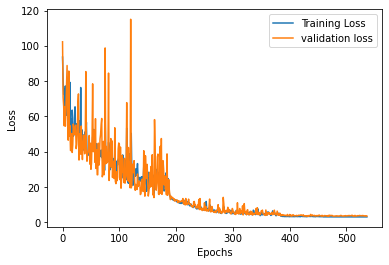

In [9]:
plt.plot(np.arange(0, len(epochal_train_losses[10:]), 1), epochal_train_losses[10:], label='Training Loss')
plt.plot(np.arange(0, len(epochal_train_losses[10:]), 1), epochal_val_losses[10:], label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

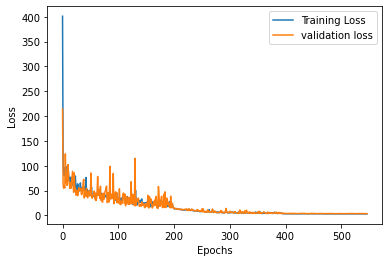

In [10]:
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_train_losses, label='Training Loss')
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_val_losses, label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

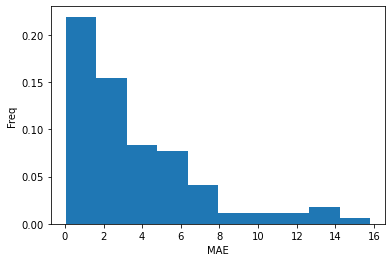

In [11]:
results = results[results[:,0].argsort()].cpu().numpy()

# plt.plot(np.arange(0, results.shape[0]), abs(results[:,1]-results[:,2]), label='Training Loss')
plt.hist(abs(results[:,1]-results[:,2]), density=True)
plt.xlabel("MAE")
plt.ylabel("Freq")
plt.show()

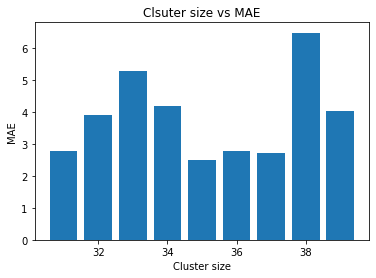

In [13]:
some_res = np.split(results[:,1:], np.unique(results[:, 0], return_index=True)[1][1:])
diff = [abs(i[:,0]-i[:,1]).mean() for i in some_res]
plt.title("Clsuter size vs MAE")
plt.bar(np.arange(31, 40), diff, label='Training Loss')
plt.xlabel("Cluster size")
plt.ylabel("MAE")
plt.show()

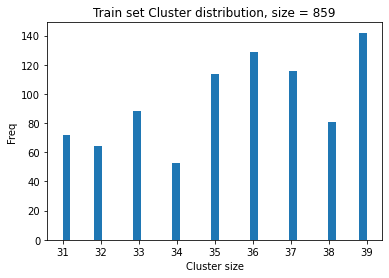

In [14]:
trainset = desc_data[train_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Train set Cluster distribution, size = {}".format(len(sizzle)))
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.hist(sizzle, bins=39)
plt.show()
# plt.savefig("cluster_distribution_trainset.png", bbox_inches='tight')

In [ ]:
trainset = desc_data[test_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Test set Cluster distribution, size = {}".format(len(sizzle)))
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.hist(sizzle, bins=39)
plt.show()
# plt.savefig("cluster_distribution_testset.png", bbox_inches='tight')

In [ ]:
trainset = desc_data[val_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Validation set Cluster distribution, size = {}".format(len(sizzle)))
plt.hist(sizzle, bins=39)
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.show()
# plt.savefig("cluster_distribution_validationset.png", bbox_inches='tight')